# BS Side Implementation-Downlink Time/Frame Synchronization using PSS in 5G Networks

Downlink time/frame synchronization using Primary Synchronization Signal (PSS) in 5G networks is a vital procedure for ensuring precise timing alignment between the base station (gNB) and user equipment (UE). Here's a more accurate breakdown:

1. **Purpose of Synchronization**: Synchronization is crucial for coordinating transmission and reception in wireless networks. In the downlink direction, precise synchronization ensures that UEs can correctly receive and decode the transmitted signals from the base station.
2. **Primary Synchronization Signal (PSS)**: PSS is a specific signal transmitted periodically by the base station. It consists of unique sequences known as primary synchronization sequences, which convey critical information such as cell identity and timing.
3. **UE Synchronization Process**: When a UE attempts to connect to a 5G network, it scans for nearby cells and detects PSS signals. By decoding the PSS, the UE identifies the cell's identity and estimates the timing offset between its internal clock and the base station's clock.
4. **Frame Synchronization**: Alongside time synchronization, frame synchronization ensures that the UE accurately identifies the boundaries of radio frames transmitted by the base station. This synchronization is essential for proper reception and processing of control and data information within each frame.
5. **Accurate Resource Allocation**: Precise time/frame synchronization enables efficient resource allocation by the base station. Aligned UEs allow optimal utilization of available resources, enhancing system capacity and throughput.
6. **Benefits and Impact**: Accurate downlink synchronization using PSS enhances overall network performance by improving reception quality, facilitating seamless handovers, and enabling efficient resource management. It ensures robust connectivity and enhances the user experience in 5G networks.

In summary, downlink time/frame synchronization using PSS is critical for ensuring reliable and efficient communication in 5G networks, providing precise timing alignment between base stations and user devices for seamless operation and optimal performance.


## 3.1 Import Libraries

### 3.1 Import Some Basic Python Libraries

In [1]:

# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

import numpy as np
import adi


### 3.1 Import 5G Libraries

In [2]:

from toolkit5G.SequenceGeneration import PSS, SSS, DMRS
from toolkit5G.PhysicalChannels   import PBCH, PBCHDecoder
from toolkit5G.ResourceMapping    import SSB_Grid, ResourceMapperSSB
from toolkit5G.OFDM               import OFDMModulator, OFDMDemodulator
from toolkit5G.MIMOProcessing     import AnalogBeamforming, ReceiveCombining
from toolkit5G.ReceiverAlgorithms import PSSDetection, SSSDetection, ChannelEstimationAndEqualization, DMRSParameterDetection
from toolkit5G.Configurations     import TimeFrequency5GParameters, GenerateValidSSBParameters


## 3.1 Emulation Parameters

In [3]:
# System Parameters
center_frequency    = 1e9     # Carrier frequency for signal transmission

# OFDM Parameters
Bandwidth           = 5*10**6 # bandwidth
fftSize             = 1024    # FFT-size for OFDM
subcarrier_spacing  = 15000   # Subcarrier spacing
numOFDMSymbols      = 14      # Number of OFDM symbols considered for emulation | 1 slot
sample_rate         = fftSize*subcarrier_spacing # sample rate required by OFDM and DAC/ADC of SDR

# Pulse Shaping
numSamplesPerSymbol = 1


# number of samples returned per call to rx()
buffer_size         = int(fftSize*1.2*numSamplesPerSymbol*numOFDMSymbols)


## 3.1 Generate SSB Parameters

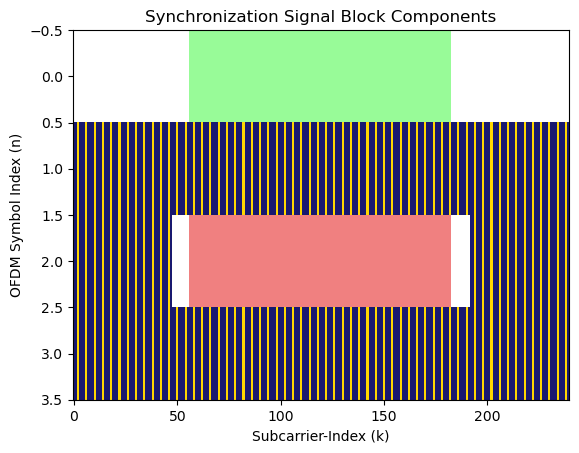

In [4]:
## This class fetches valid set of 5G parameters for the system configurations
nSymbolFrame= int(140*subcarrier_spacing/15000)
## This class fetches valid set of 5G parameters for the system configurations 
tfParams    = TimeFrequency5GParameters(Bandwidth, subcarrier_spacing)
tfParams(nSymbolFrame, typeCP = "normal")
nRB         = tfParams.numRBs        # SSB Grid size (Number of RBs considered for SSB transition)
Neff        = tfParams.Neff        # Number of resource blocks for Resource Grid ( exclude gaurd band | offsets : BWP)
Nfft        = 512                 # FFT-size for OFDM
lengthCP    = tfParams.lengthCP    # CP length
#___________________________________________________________________

#### Generate MIB Information
lamda                           = 3e8/center_frequency;
nSCSOffset                      = 1
ssbParameters                   = GenerateValidSSBParameters(center_frequency, nSCSOffset, "caseA", ssbSubCarrierOffset = np.array([0]))

systemFrameNumber               = ssbParameters.systemFrameNumber
subCarrierSpacingCommon         = subcarrier_spacing
ssbSubCarrierOffset             = ssbParameters.ssbSubCarrierOffset
DMRSTypeAPosition               = ssbParameters.DMRSTypeAPosition
controlResourceSet0             = ssbParameters.controlResourceSet0
searchSpace0                    = ssbParameters.searchSpace0

isPairedBand                    = ssbParameters.isPairedBand
nSCSOffset                      = ssbParameters.nSCSOffset
choiceBit                       = ssbParameters.choiceBit
ssbType                         = ssbParameters.ssbType
nssbCandidatesInHrf             = ssbParameters.nssbCandidatesInHrf
ssbIndex                        = ssbParameters.ssbIndex
hrfBit                          = ssbParameters.hrfBit
cellBarred                      = ssbParameters.cellBarred
intraFrequencyReselection       = ssbParameters.intraFrequencyReselection
withSharedSpectrumChannelAccess = ssbParameters.withSharedSpectrumChannelAccess

Nsc_ssb                         = 240
Nsymb_ssb                       = 4
#_______________________________________


N_ID2        = np.random.randint(3)

# Generate PSS sequence
pssObject    = PSS(N_ID2);
pssSequence  = pssObject()

N_ID1        = np.random.randint(336)
N_ID         = 3*N_ID1 + N_ID2

# Generate SSS sequence
sssObject    = SSS(N_ID1, N_ID2);
sssSequence  = sssObject()

# Generate DMRS sequence
dmrsLen      = 144;
dmrsObject   = DMRS("PBCH", N_ID, ssbIndex, nssbCandidatesInHrf, hrfBit)
# dmrsSeq = dmrs.getSequence("tensorflow")
dmrsSequence = dmrsObject(dmrsLen)


# Generate PBCH symbols
pbchObject   = PBCH(center_frequency, choiceBit, subCarrierSpacingCommon, DMRSTypeAPosition,
                   controlResourceSet0, searchSpace0, cellBarred, intraFrequencyReselection,
                   systemFrameNumber, ssbSubCarrierOffset, hrfBit, ssbIndex, N_ID,
                   nssbCandidatesInHrf)

pbchSymbols  = pbchObject()

## Generate SSB Object
ssbObject    = SSB_Grid(N_ID, True)
ssb          = ssbObject(pssSequence, sssSequence, dmrsSequence, pbchSymbols)

## Loading SSB to Resource Grid
#####################################
# ssbPositionInBurst = np.ones(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst    = np.zeros(nssbCandidatesInHrf, dtype=int)
ssbPositionInBurst[0] = 1

ssbRGobject    = ResourceMapperSSB(ssbType=ssbType, carrierFrequency = center_frequency, 
                                   isPairedBand = isPairedBand, 
                                   withSharedSpectrumChannelAccess = withSharedSpectrumChannelAccess)

ssbGrid = ssbRGobject(ssb[0], ssbPositionInBurst, offsetInSubcarriers = ssbSubCarrierOffset[0],
                      offsetInRBs = 0, numRBs = nRB)[0:14]
fig, ax = ssbObject.displayGrid(option=1)

## 3.1 Construct Transmission Grid and Generate Time Domain Samples

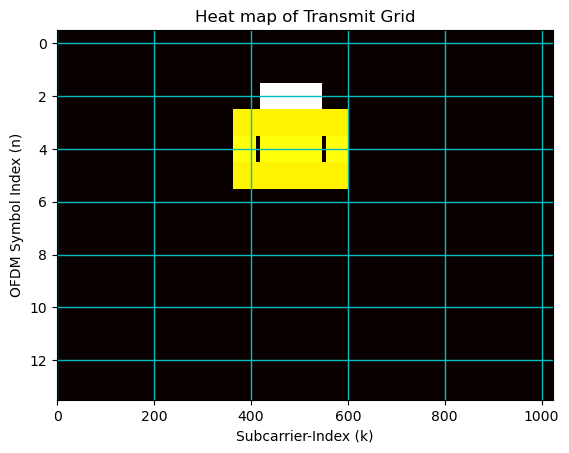

In [5]:
## Loading SSB to Resource Grid
numofGuardCarriers = (int((fftSize - Neff)/2), int((fftSize - Neff)/2))
offsetToPointA     = 0
firstSCIndex       = int(numofGuardCarriers[0] + offsetToPointA)
numOFDMSymbols     = ssbGrid.shape[0]

X = np.zeros((numOFDMSymbols, fftSize), dtype= np.complex64)
X[:, firstSCIndex:firstSCIndex+ssbGrid.shape[-1]] = ssbGrid

#__________________________________________________

## OFDM Modulation at Transmitter
#####################################
modulator = OFDMModulator(lengthCP[1])
x_time    = modulator(X).flatten()
#______________________________________________________

# Plot Resource Grid
#################################################################
fig, ax = plt.subplots()
plt.imshow(np.abs(X), cmap = 'hot', interpolation='nearest', aspect = "auto")
ax = plt.gca();
ax.grid(color='c', linestyle='-', linewidth=1)
ax.set_xlabel("Subcarrier-Index (k)")
ax.set_ylabel("OFDM Symbol Index (n)")
ax.set_title("Heat map of Transmit Grid")
# Gridlines based on minor ticks
plt.show()

## 3.1 SDR-Setup Configurations

In [6]:

# SDR setup
sdr             = adi.Pluto("ip:192.168.2.1")       # Create object of SDR setup object and configure the IP of SDR connect to the system
sdr.sample_rate = int(sample_rate)                  # Sets the sample rate for the ADC/DAC of the SDR.

# Config Tx
sdr.tx_rf_bandwidth         = int(sample_rate)      # Set the bandwidth of the transmit filter | Can be set same as the sample rate
# For Pluto SDR, tx_rf_bandwidth should be between 200 kHz and 56 MHz.
sdr.tx_lo                   = int(center_frequency) # Sets the transmitter local oscillator frequency. The carrier is used to modulate/up-convert the analog information signal.
# For Pluto SDR, tx_lo can take a value between 325 MHz to 3.8 GHz.
sdr.tx_hardwaregain_chan0   = 0                     # Sets the gain (dB) of the transmitter power amplifier. The higher the value the more the power radiated by antenna. 
# For Pluto SDR, tx_hardwaregain_chan0 can take values between -90 to 0.


## 3.1 Transmission: SDR RF Transmitter

In [7]:

# Start the transmitter
sdr.tx_cyclic_buffer = True # Enable cyclic buffers
# sdr.tx_cyclic_buffer = False # Enable cyclic buffers
sdr.tx(1.3*2**17*(x_time.repeat(1))) # start transmitting
